# Activity: Auditing Bias in Medical Risk Prediction

**Initial Due Date: 2026-01-14 10:00AM**  
**Final Due Date: 2026-01-19 4:15PM**

## Learning Objectives

By the end of this activity, you will be able to:

-   Describe one complex mechanism that can lead to bias in the allocation of resources by predictive algorithms.
-   Reproduce key findings from a published study documenting racial bias in a medical risk prediction algorithm.

## Introduction: Allocation and Bias

Automated prediction systems are often used to make or inform *decisions* that affect people’s lives. Often these decisions relate to the *allocation* of resources:

-   Who should receive a job opportunity?
-   Who should be able to rent a rent-stabilized apartment?
-   Who should receive intensive medical treatment?

When these algorithms make systematically different allocative recommendations for different groups of people, awarding resources to some while denying those same resources to others for arbitrary reasons, we may have an instance of *allocative harm* @crawfordTroubleBias2017 or *allocative bias*.

In this activity we’ll explore a famous case of allocative bias in the distribution of medical care, documented in the journal article *[Dissecting Racial Bias in an Algorithm Used to Manage the Health of Populations](https://www.science.org/doi/full/10.1126/science.aax2342) by Ziad Obermeyer, Brian Powers, Christine Vogeli, and Sendhil Mullainathan (*Science\*, 2019).

In this study, the authors considered a healthcare recommendation system which assigned a *medical risk score* to patients; patients with higher scores were considered to face greater future risk to their health. Patients who received very high risk scores were recommended for an intensive care program intended to improve their outcomes. Here, it’s important to remember:

> *If* a patient is indeed at high medical risk, then it is a *good* outcome for them to receive a high risk score and be recommended for intensive care.

## Part A: Read The Article

Take ~30 minutes to read through the article. <span class="column-margin margin-aside">The PDF version of this article can be directly accessed at [this link](https://www.ftc.gov/system/files/documents/public_events/1548288/privacycon-2020-ziad_obermeyer.pdf) hosted by the FTC.</span> You can focus on the first four pages of the text, especially including the abstract, the description of the data set, Fig. 1 and surrounding text, and the section “Mechanism of bias.”

### Exercise A1

Add a new text cell immediately below this list (or edit the placeholder text) with brief written answers to the following questions:

1.  What entity is the *developer* of the algorithm studied in the article? What entity is the *consumer* (paying user) of the algorithm? What entity or entities are the *subject* of (person(s) affected by) the algorithm?
2.  What happens to a patient who receives a very high risk score?
3.  What is the target variable that the algorithm is trained to predict?
4.  On average, how many chronic illnesses are required for a white patient to be defaulted into the high-risk management program? How many are required for a Black patient?
5.  Does a Black patient with a given risk score from the algorithm tend to have more or fewer chronic illnesses than a white patient with the same risk score?
6.  Does a Black patient with a given risk score from the algorithm tend to have higher or lower medical costs than a white patient with the same risk score?
7.  Please respond to the following statement: “The algorithm studied in this article can’t be racially biased because it is equally accurate in predicting medical costs for Black and white patients.” Explain your reasoning.

*[TODO: Your response here]*

### Part B: Reproducing Findings From Obermeyer et al.

The authors of this study collected sensitive medical and demographic data for a large set of hospital patients, along with the risk scores assigned to those patients by the recommendation system. They then released a *synthetic version* of the data set, in which many features were randomized and anonymized but important correlations in the data were preserved. This means that we can reproduce many of the analyses of the paper for ourselves. The remainder of this activity will guide us through a partial reproduction of the study’s findings.

The code below will import several packages, download the synthetic data set, and load it into a pandas DataFrame:

In [26]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression

sns.set_theme(style="whitegrid", context="notebook")
sns.set_palette("viridis", n_colors=2)

url = "https://gitlab.com/labsysmed/dissecting-bias/-/raw/master/data/data_new.csv?inline=false"
df = pd.read_csv(url)
df.head()

,risk_score_t,program_enrolled_t,cost_t,cost_avoidable_t,bps_mean_t,ghba1c_mean_t,hct_mean_t,cre_mean_t,ldl_mean_t,race,...,trig_min-high_tm1,trig_min-normal_tm1,trig_mean-low_tm1,trig_mean-high_tm1,trig_mean-normal_tm1,trig_max-low_tm1,trig_max-high_tm1,trig_max-normal_tm1,gagne_sum_tm1,gagne_sum_t
0,1.987430,0,1200.0,0.0,NaN,5.4,NaN,1.110000,194.0,white,...,0,0,0,0,0,0,0,0,0,0
1,7.677934,0,2600.0,0.0,119.0,5.5,40.4,0.860000,93.0,white,...,0,1,0,0,1,0,0,1,4,3
2,0.407678,0,500.0,0.0,NaN,NaN,NaN,NaN,NaN,white,...,0,0,0,0,0,0,0,0,0,0
3,0.798369,0,1300.0,0.0,117.0,NaN,NaN,NaN,NaN,white,...,0,0,0,0,0,0,0,0,0,0
4,17.513165,0,1100.0,0.0,116.0,NaN,34.1,1.303333,53.0,white,...,0,0,0,0,0,0,0,0,1,1


In this data, patients status in the intensive care program was informed by the value of the risk score. Risk scores in the 97th percentile and above (so, the top 3% of patients with the most predicted risk) were *automatically enrolled* in the program, while patients with risk scores in the 55th to 96th percentiles were *screened* for possible enrollment. Patients with risk scores below the 55th percentile were not considered for enrollment.

For the meaning of the columns in the data frame, please refer to the [data dictionary](https://gitlab.com/labsysmed/dissecting-bias/-/blob/master/data/data_dictionary.md?ref_type=heads) supplied by the authors.

### Exercise B1

Please write a quick one-liner which adds the *percentile* risk score as an integer column in the data frame named “percentile_risk_score_t”. If a given patient has a risk score higher than 70% of all patients, their percentile risk score should be 70. While there are many good ways to do this, it’s possible to achieve this in one long-ish line using the `rank` method of pandas Series objects.

In [72]:
df["percentile_risk_score_t"] = (df["risk_score_t"].rank(pct=True) * 100).astype(int)
df.head()

,risk_score_t,program_enrolled_t,cost_t,cost_avoidable_t,bps_mean_t,ghba1c_mean_t,hct_mean_t,cre_mean_t,ldl_mean_t,race,...,trig_mean-normal_tm1,trig_max-low_tm1,trig_max-high_tm1,trig_max-normal_tm1,gagne_sum_tm1,gagne_sum_t,percentile_risk_score_t,not_enrolled,screened,auto_enrolled
0,1.987430,0,1200.0,0.0,NaN,5.4,NaN,1.110000,194.0,white,...,0,0,0,0,0,0,35,True,False,False
1,7.677934,0,2600.0,0.0,119.0,5.5,40.4,0.860000,93.0,white,...,1,0,0,1,4,3,86,False,True,False
2,0.407678,0,500.0,0.0,NaN,NaN,NaN,NaN,NaN,white,...,0,0,0,0,0,0,3,True,False,False
3,0.798369,0,1300.0,0.0,117.0,NaN,NaN,NaN,NaN,white,...,0,0,0,0,0,0,11,True,False,False
4,17.513165,0,1100.0,0.0,116.0,NaN,34.1,1.303333,53.0,white,...,0,0,0,0,1,1,97,False,False,True


### Exercise B2

Now write code which adds three new boolean columns to the data frame named “not_enrolled”, “screened”, “auto_enrolled”, indicating whether a patient was (a) not enrolled in intensive care, (b) screened for possible enrollment, or (c) automatically enrolled. Use the percentile risk score to determine these values. Recall that you can use the `&` (and), `|` (or), and `~` (not) operators to combine boolean conditions in Pandas, but we be careful about the parentheses to ensure the desired order of operations.

In [73]:
df["not_enrolled"] = df["percentile_risk_score_t"] < 55
df["screened"] = (df["percentile_risk_score_t"] > 55) & (df["percentile_risk_score_t"] < 96)
df["auto_enrolled"] = df["percentile_risk_score_t"] > 97
df.head()

,risk_score_t,program_enrolled_t,cost_t,cost_avoidable_t,bps_mean_t,ghba1c_mean_t,hct_mean_t,cre_mean_t,ldl_mean_t,race,...,trig_mean-normal_tm1,trig_max-low_tm1,trig_max-high_tm1,trig_max-normal_tm1,gagne_sum_tm1,gagne_sum_t,percentile_risk_score_t,not_enrolled,screened,auto_enrolled
0,1.987430,0,1200.0,0.0,NaN,5.4,NaN,1.110000,194.0,white,...,0,0,0,0,0,0,35,True,False,False
1,7.677934,0,2600.0,0.0,119.0,5.5,40.4,0.860000,93.0,white,...,1,0,0,1,4,3,86,False,True,False
2,0.407678,0,500.0,0.0,NaN,NaN,NaN,NaN,NaN,white,...,0,0,0,0,0,0,3,True,False,False
3,0.798369,0,1300.0,0.0,117.0,NaN,NaN,NaN,NaN,white,...,0,0,0,0,0,0,11,True,False,False
4,17.513165,0,1100.0,0.0,116.0,NaN,34.1,1.303333,53.0,white,...,0,0,0,0,1,1,97,False,False,False


So, how likely is a patient with some given medical characteristics and demographic profile to receive a high risk score? Rather than work with the many medical variables in the data set, we’ll follow the authors and focus on the number of active chronic illnesses a patient has in the year preceding the experiment, which are summarized in the variable `gagne_sum_tm1`. One might reasonably expect that patients with more chronic illnesses would be more likely to receive high risk scores.

### Exercise B3

Write code which produces line plots showing the proportion of patients recommended for intensive care (either screened or automatically enrolled) as a function of the number of chronic illnesses they have. Produce separate lines for Black and white patients, and separate panels for male and female patients. The vast majority of patients have 10 or fewer chronic illnesses, so for visualization purposes it’s fine to restrict the x-axis to this range.

Some suggestions:

-   Recall the “monthly max” histograms in the wrangling activity, the Seaborn figure level functions have `row` and `col` arguments which create subplots (along the row or column, respectively) for the values of provided variables.
-   Checkout the same example for how to create titles for each subplot based on the specific value of the facetting variable.

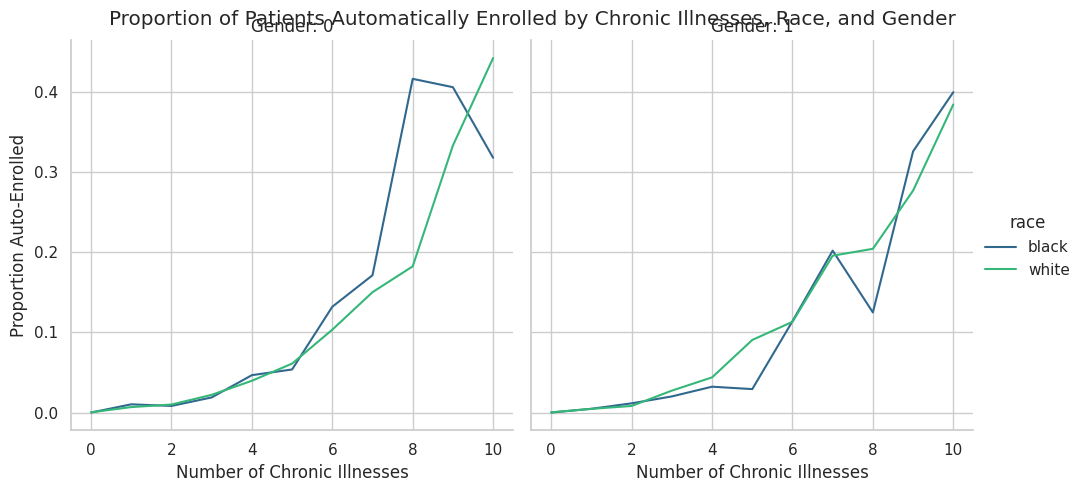

In [74]:
df_recommended = df.groupby(['gagne_sum_tm1', 'race', 'dem_female'])['auto_enrolled'].mean().reset_index()

graph = sns.relplot(
    data=df_recommended[df_recommended['gagne_sum_tm1'] <= 10],
    x='gagne_sum_tm1',
    y='auto_enrolled',
    hue='race',
    col='dem_female',
    kind='line',
)
graph.set_axis_labels('Number of Chronic Illnesses', 'Proportion Auto-Enrolled')
graph.set_titles('Gender: {col_name}')
plt.suptitle('Proportion of Patients Automatically Enrolled by Chronic Illnesses, Race, and Gender')
plt.show()

## Part C: Sources of Bias

It is a common trope that bias in an automated decision system is a consequence of “biased data.” This is not necessarily false, but it is important to be specific about the details. It is also important to consider the *design decisions* that go into building and training these systems.

The model used to assign risk scores to patients in this case was trained to predict *future healthcare costs* based on past medical and demographic data. The idea here is that “health risk” isn’t a well-defined, measurable concept, but healthcare *costs* are. So, an algorithm that can predict the healthcare *costs* incurred by a patient might be a useful proxy for predicting their *health risk*.

### Exercise C1

Let’s first check whether the total healthcare cost is truly correlated with risk score. Make a plot showing the average healthcare cost incurred by patients at each percentile of risk score. Use a logarithmic scale for the y-axis, since healthcare costs vary widely across patients.

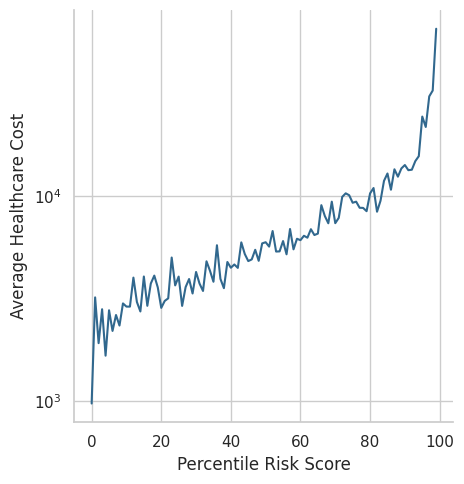

In [75]:
mean_cost = df.groupby('percentile_risk_score_t')['cost_t'].mean().reset_index()
ax = sns.relplot(
    data=mean_cost,
    x='percentile_risk_score_t',
    y='cost_t',
    kind='line',
)
ax.set_axis_labels('Percentile Risk Score', 'Average Healthcare Cost')
plt.yscale('log')
plt.show()

### Exercise C2

The assumption of training a model on healthcare *costs* is that these costs should be correlated with their health *risks*. Make a plot showing the average healthcare cost incurred by patients as a function of the number of chronic illnesses they had in the previous year. You may wish to restrict the horizontal axis to patients with 5 or fewer chronic illnesses, since very few patients have more than this number. Use a logarithmic scale for the y-axis, since healthcare costs vary widely across patients.

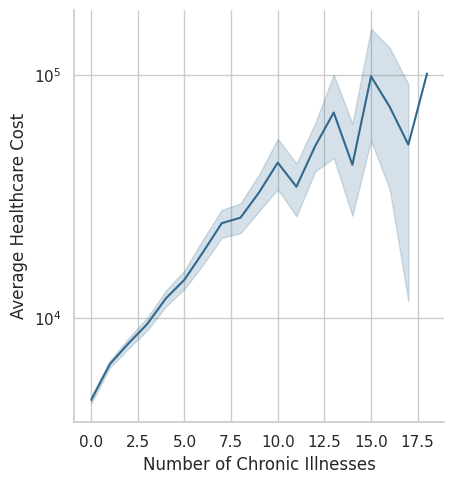

In [76]:
ax = sns.relplot(data=df,
                 x='gagne_sum_tm1',
                 y='cost_t',
                 kind='line',
                 )
ax.set_axis_labels('Number of Chronic Illnesses', 'Average Healthcare Cost')
plt.yscale('log')
plt.show()

### Exercise C3

Now make a similar line plot showing the average healthcare cost incurred by patients as a function of the number of chronic illnesses they had in the previous year, but this time produce separate lines for Black and white patients. Then a new text cell immediately below the plot (or edit the placeholder text) to briefly comment on your findings. What implications do these findings have for using healthcare costs as a proxy for health risk?

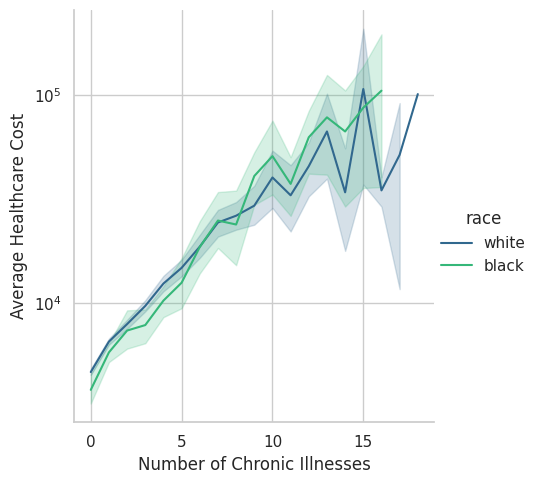

In [82]:
ax = sns.relplot(data=df,
                 x='gagne_sum_tm1',
                 y='cost_t',
                 kind='line',
                 hue='race',
                 )
ax.set_axis_labels('Number of Chronic Illnesses', 'Average Healthcare Cost')
plt.yscale('log')
plt.show()

*[TODO: Your response here]*

## Part D: Estimating Cost Disparity

It’s possible to use a regression model to estimate the the magnitude of the disparity in healthcare costs between Black and white patients, by race.

### Exercise D1

Please fit a linear regression model to predict total healthcare costs (`cost_t`) using race, gender, age, and number of chronic illnesses (in the previous year) as features. For simplicity, restrict your analysis to patients with 5 or fewer chronic illnesses. Then, generate a table of coefficients from your fitted model and show it. Comment on the coefficient corresponding to race. Does it align directionally with the findings of the article?

Suggestions:

-   You will need to do some data wrangling, and particularly one-hot encoding, to prepare the data for modeling. Recall from class that the [`pd.get_dummies`](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html) function can be used to one-hot encode variables.
-   Recall from class how used `sklearn.linear_model.LinearRegression` to fit a linear regression model.

> #### ⚠️ This is a simplified analysis
>
> This is a simplified analysis for educational purposes only. A more careful statistical analysis would be necessary to obtain a reliable estimate of cost disparity.

In [ ]:
# TODO: Your code here

*[TODO: Your response here]*

## Collaboration statement

In a new text cell immediately below this paragraph (or by editing this text cell to add a paragraph), briefly list who or what you collaborated with and how. Cite any sources here or with relevant inline comments in your code. Acknowledge all contributors, both people and AI, and what portions of this notebook they contributed. You do not need to cite or acknowledge any material provided in the starter file(s).

## Submitting your notebook

You will simultaneously submit the following two files to the relevant assignment on [Gradescope](https://gradescope.com) via the “Upload option” (guide [here](https://guides.gradescope.com/hc/en-us/articles/21865616724749-Submitting-a-Code-assignment)). **Both files must be uploaded at the same time and the file names must match the specification exactly for the autotesting to run successfully.**

1.  `activity_dissecting_bias.ipynb`: Your completed IPython notebook. You can obtain this via the “File→Download→Download .ipynb” menu option in Colab.
2.  `activity_dissecting_bias.py`: Your completed IPython notebook as a Python file. You can obtain this via the “File→Download→Download .py” menu option in Colab. This file is used to provide line-level feedback on your submission.

You can submit multiple times, with only the most recent submission (before the final due date) assessed for credit. Gradescope will run a series of automated unit tests on your notebook (which may takes 10s of seconds depending on the complexity of the notebook). Note that the tests performed by Gradescope are limited. Passing all of the visible tests does not guarantee that your submission correctly satisfies all of the requirements of the assignment.